
Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---


## Recap
 
###  Module 2.3.1

- Choose your target. Which column in your tabular dataset will you predict?
- Is your problem regression or classification?
- How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- Choose your evaluation metric(s).
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- Begin to clean and explore your data.
- Begin to choose which features, if any, to exclude. Would some features "leak" future information?

### Module 2.3.2

- Explore tabular data for supervised machine learning
- Join relational data for supervised machine learning
  - pandas.DataFrame.merge(https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html)

### Module 2.3.3

- Try xgboost.
- Get your model's permutation importances. 


### Module 2.3.4

More types of model explanations 
#### 1. Global model explanation: all features in relation to each other
- Feature Importances: _Default, fastest, good for first estimates_
- Permutaton Importances: _A good compromise!_

#### 2. Global model explanation: individual feature(s) in relation to target
- Partial Dependence plots

#### 3. Individual prediction explanation
- Shapley Values

# Model Interpretation

- Visualize and interpret **partial dependence plots**
- Explain individual predictions with **shapley value plots**

### Setup

Run the code cell below. You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab.

Libraries:

- category_encoders
- matplotlib
- numpy
- pandas
- [**pdpbox**](https://github.com/SauceCat/PDPbox)
- plotly
- scikit-learn
- scipy.stats
- [**shap**](https://github.com/slundberg/shap)
- xgboost


# Visualize and interpret partial dependence plots

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'


# I. Wrangle Data

In [2]:
import pandas as pd

In [3]:
def wrangle(filepath):
    # Import CSV, set issue date to index
    df = pd.read_csv(filepath, 
                     parse_dates=['issue_d'],
                     index_col='issue_d').sort_index()

    # Just use 36 month loans
    df = df[df.term ==' 36 months']

    # Clean data col names
    df = df.rename(columns=                     
      {'annual_inc': 'annual_income', 
        'fico_range_high': 'credit_score', 
        'funded_amnt': 'loan_amount', 
        'title': 'loan_purpose'}) 
    # Engineer features
    df['interest_rate'] = df['int_rate'].str.strip('%').astype(float)
    df['monthly_debts'] = df['annual_income'] / 12 * df['dti'] / 100

    cols = ['annual_income',
          'credit_score',
          'interest_rate',
          'loan_amount',
          'loan_purpose',
          'monthly_debts']
    df = df[cols]
    # Drop rows with NaN values
    df.dropna(inplace=True)
    # never use fillna with mean, median, mode and other population parameter - avoid data leakage
    df['loan_purpose'] = df['loan_purpose'].str.lower().str.strip()
    purpose_list = ['credit', 'mortgage', 'consoli', 'debt']
    
    def fr(content):
        for purpose in purpose_list:
            if purpose in content:
                return purpose
        return 'others'  

    df['loan_purpose'] = df['loan_purpose'].apply(fr)

        # Remove rows where salary is more than $1 million
    df = df[(df['annual_income'] > 200000)&(df['annual_income'] < 1000000)]

    return df

In [4]:
df = wrangle(DATA_PATH+'lending-club/lending-club-subset.csv')


# II. Split Data

Split **feature matrix** from **target vector**


In [5]:
target = 'interest_rate'
y = df[target]
X = df.drop(columns=target)

In [6]:
cutoff = int(len(X) * 0.8)
X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

# III. Establish Baseline

In [7]:
from sklearn.metrics import mean_absolute_error
baseline_mae = mean_absolute_error(y_train, [y_train.mean()]*len(y_train))
print('baseline mae is', baseline_mae)

baseline mae is 3.102406289089973


# IV. Build the model

### Fit Linear Regression model

In [8]:
from category_encoders import OneHotEncoder,OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

model_lr = make_pipeline(OneHotEncoder(use_cat_names=True),
                         LinearRegression())
model_lr.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['loan_purpose'], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=True, verbose=0)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

### Explaining Linear Regression

In [9]:
coefficients = model_lr.named_steps['linearregression'].coef_
features = model_lr.named_steps['onehotencoder'].get_feature_names()
pd.Series(coefficients, features)

annual_income           5.058645e-07
credit_score           -5.407556e-02
loan_amount             5.926725e-05
loan_purpose_credit    -1.917616e+00
loan_purpose_others     8.722006e-01
loan_purpose_consoli   -4.961462e-01
loan_purpose_debt       1.541561e+00
monthly_debts          -6.854546e-05
dtype: float64

### Fit Gradient Boosting model

In [10]:
from xgboost import XGBRegressor
# Because shap plot did not accept the pipeline, so you can decompose your pipeline to individual steps!
oe = OrdinalEncoder()
X_train_T = oe.fit_transform(X_train)
model_gb = XGBRegressor(random_state=42, n_jobs=10)
model_gb.fit(X_train_T, y_train)

[19:23:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=10, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

# V. Check Metrics 

In [11]:
print('Linear regression MAE is ', mean_absolute_error(y_test, model_lr.predict(X_test)))
print('Gradient Boosting MAE is', mean_absolute_error(y_test, model_gb.predict(oe.transform(X_test))))

Linear regression MAE is  2.934730865319094
Gradient Boosting MAE is 2.7940503093364626


# VI. Communicate Results

### Partial Dependence Plots with 1 feature

PDPbox
- [Gallery](https://github.com/SauceCat/PDPbox#gallery)
- [API Reference: pdp_isolate](https://pdpbox.readthedocs.io/en/latest/pdp_isolate.html)
- [API Reference: pdp_plot](https://pdpbox.readthedocs.io/en/latest/pdp_plot.html)


In [12]:
# Later, when you save matplotlib images to include in blog posts or web apps,
# increase the dots per inch (double it), so the text isn't so fuzzy
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f5380a95650>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f538221b550>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


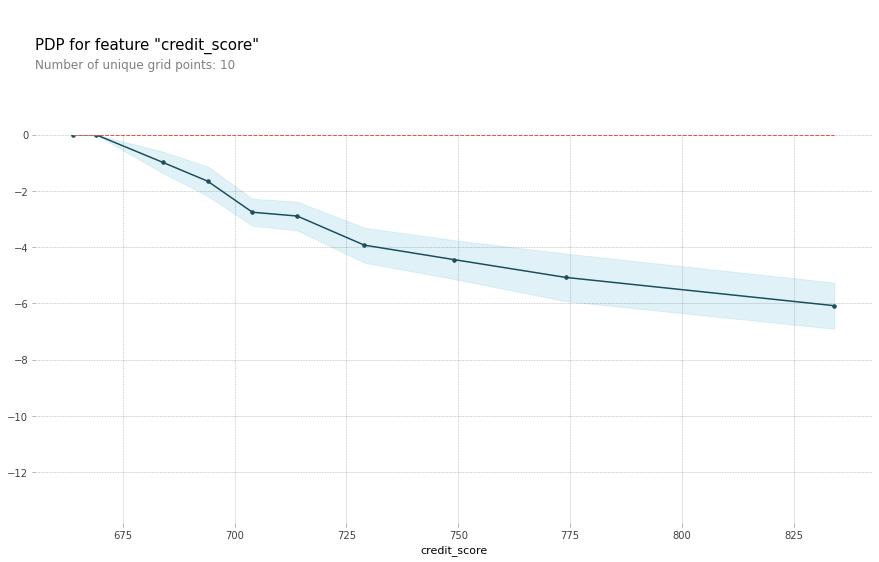

In [13]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'credit_score'

isolate = pdp_isolate(
          model=model_gb,
          dataset=oe.transform(X_test),
          model_features=oe.transform(X_test).columns,
          feature=feature
)

pdp_plot(isolate, feature_name=feature)

### Partial Dependence Plots with 2 features


(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f53812744d0>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f537ef7a590>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


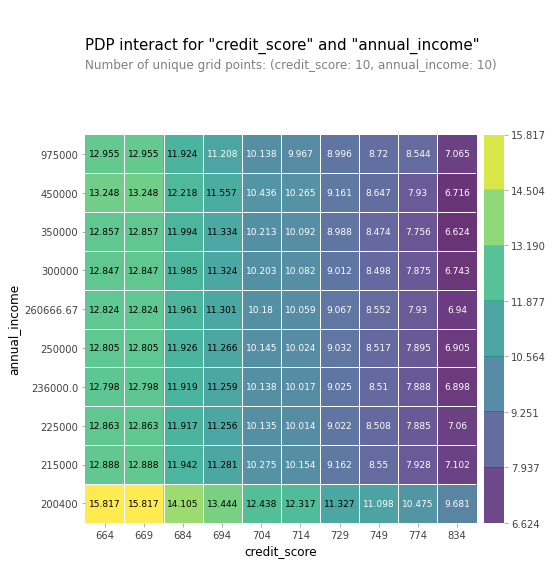

In [14]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

feature = ['credit_score','annual_income']

interact = pdp_interact(
          model=model_gb,
          dataset=oe.transform(X_test),
          model_features=oe.transform(X_test).columns,
          features=feature
)

pdp_interact_plot(interact, plot_type='grid', feature_names=feature)

# Explain individual predictions with shapley value plots

## Overview

We’ll use TreeExplainer from an awesome library called [SHAP](https://github.com/slundberg/shap), for “additive explanations” — we can explain individual predictions by seeing how the features add up!

<img src="https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/shap_header.png" width="800" />

In [15]:
# Grab a single observation from our test data
row = X_test.iloc[[128]]
row

,annual_income,credit_score,loan_amount,loan_purpose,monthly_debts
issue_d,,,,,
2017-06-01,223000.0,704.0,35000.0,consoli,1237.65


In [16]:
model_gb.predict(oe.transform(row))

array([12.217909], dtype=float32)

In [17]:
from shap import TreeExplainer, initjs, force_plot

explainer = TreeExplainer(model_gb)# <-- Does not like `sklearn` pipelines

initjs()

force_plot(
    base_value=explainer.expected_value,
    shap_values=explainer.shap_values(oe.transform(row)),
    features=row
)